**Using OCR for Document Integrity Checking**

Packaged Included

In [1]:
import numpy as np
from imutils import contours
import cv2
import pytesseract
from matplotlib import pyplot as plt
from skimage.transform import resize

Image Pre-Processing

Binarization methods using Otsu

In [2]:
#Function to load the image and convert to grayscale
def load_image(path):
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def binary_preprocess(image):
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh

Noise Reduction methods

1. Gaussian filter
2. Non-local means

In [3]:
def noise_reduction(image, method):
    if(method == "gaussian"):
        blur = cv2.GaussianBlur(image, (5,5), 0)
    else:
        blur = image
        cv2.fastNlMeansDenoising(image, blur, 3, 7, 21)
    return blur

Image Sharpening methods

Using Unsharp Mask

In [4]:
def image_sharpen(image, method = "unsharp"):
    if(method == "unsharp"):
        gaussian = cv2.GaussianBlur(image, (5, 5), 0)
        unsharp_image = cv2.addWeighted(image, 2.0, gaussian, -1.0, 0)
    return unsharp_image

Geometric Transformation using skew correction

In [5]:
#Determine the rotated angle
def turned_angle(img) -> float:
    newImage = img.copy()
    blur = cv2.GaussianBlur(newImage, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    largestContour = sorted(contours, key = cv2.contourArea, reverse = True)[0]
    minAreaRect = cv2.minAreaRect(largestContour)
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle, largestContour

# Rotate the image
def rotate(img, angle: float):
    newImage = img.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

def deskew(img):
    angle, contour = turned_angle(img)
    return rotate(img, -1.0 * angle),contour

Obtaining the Region of Interest

In [6]:
def region_of_interest(orig, image):
    
    crop_img = []
    shapes =[]

    # Invert image
    invert = 255 - image
    thresh = 0
    # Find contours
    contour = cv2.findContours(invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = contour[0] if len(contour) == 2 else contour[1]
    #(contour, _) = contours.sort_contours(contour, method="top-to-bottom")
    #contour = sorted(contour, key=lambda contour: abs(cv2.boundingRect(contour)[0]) + abs(cv2.boundingRect(contour)[1])* orig.shape[1])
    cnts = []
    if(orig.shape == (6992, 4938)):
        thresh = 100
        for c in contour:
            area = cv2.contourArea(c)
            if area > 90000 and area < 20000000:
                cnts.append(c)
                x, y, w, h = cv2.boundingRect(c)
                shapes.append([x, y, w, h])
                
    else:
        thresh = 50
        for c in contour:
            area = cv2.contourArea(c)
            if area > 30000 and area < 6000000:
                cnts.append(c)
                x, y, w, h = cv2.boundingRect(c)
                shapes.append([x, y, w, h])
                
    
    #sorting contours algorithm
    cnts = sorted(cnts, key=lambda cnts: abs(cv2.boundingRect(cnts)[0]) + abs(cv2.boundingRect(cnts)[1])* orig.shape[1])
    sorted_cnts = []
    for i,c in enumerate(cnts):
        x, y, w, h = cv2.boundingRect(c)
        present = False
        
        for con in sorted_cnts:
            xx, yy, ww, hh = cv2.boundingRect(con)
            if (xx == x) and (yy == y) and (ww == w) and (hh == h):
                present = True
        if(present == True):
            continue
        
        y_prime = y + thresh
        rest = []
        rest.append(c)
        for c1 in cnts[i+1:]:
            x1, y1, w1, h1 = cv2.boundingRect(c1)
            if y1 < y_prime:
                rest.append(c1)
        rest = sorted(rest, key=lambda rest: abs(cv2.boundingRect(rest)[0]))
        for c2 in rest:
            sorted_cnts.append(c2)
        
        
                
    #Crop images
    shapes = []
    for c in sorted_cnts:
        x, y, w, h = cv2.boundingRect(c)
        shapes.append([x, y, w, h])
        cropped_image = orig[y:y+h, x:x+w]
        crop_img.append(cropped_image)
        
        
    plt.figure(figsize=(50,50))
    for i, img in enumerate(crop_img):
        plt.subplot(6,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #print(i, img.shape)
        plt.imsave(f'/Users/bsank/Desktop/ROI_{i}.jpg',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.suptitle("ROI of the Text", fontsize=20)
    plt.show()

    return image, invert, crop_img, shapes

Display images

In [7]:
def display_image(image, title):
    fig = plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Preprocessing images for OCR

In [8]:
def ocr_preprocess(img, i):
    if(i == 4 or i == 18):
        #crop the image into half
        y=0
        x=0
        h=img.shape[0]
        w=img.shape[1]//4
        img = img[y:y+h, x:x+w]
        #display_image(img, "Cropped")
    
    if(i == 5):
        #Remove the table and make sure only digits are visible
        image = img
        image = noise_reduction(image,"gaussian")
        image = binary_preprocess(image)
        image = 255 - image
        
        contour = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour = contour[0] if len(contour) == 2 else contour[1]
        c1 = sorted(contour, key=cv2.contourArea)
        mask = np.zeros(image.shape, np.uint8)
        msk = cv2.drawContours(mask,c1[len(c1)-8:len(c1)],-1, 255, -1)
        
        #display_image(msk, "Contour of the Table")
        bin1 = 255 - msk
        bin2 = 255 - image
        diff = cv2.absdiff(bin2, bin1)
        diff = 255 - diff
        #display_image(diff, "Content without the table")
        img = diff

    #Resize the image to increase its resolution
    (h,w) = img.shape
    
    #If digits, different structuring elements are applied
    if(i == 12 or i == 13 or i == 14):
        resize(img, (h*10, w*10), anti_aliasing=True)
        element = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
        img = cv2.dilate(img, element)
        #element = cv2.getStructuringElement(cv2.MORPH_RECT, (1,2))
        #img = cv2.dilate(img, element)
    else:
        resize(img, (h*10, w*10), anti_aliasing=True)
        img = image_sharpen(img)
        element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        img = cv2.erode(img, element)
        element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        img = cv2.dilate(img, element)
        
    #display_image(img, "Preprocessed before OCR")
    return img
    

Detect texts from the ROI using OCR

In [9]:
def tesseract_ocr(image_array):
    ocr_output = []
    pytesseract.pytesseract.tesseract_cmd = r'C:\Users\bsank\anaconda3\envs\tesseract\Library\bin\tesseract.exe'
    print("Texts recognised by OCR")
    for i, img in enumerate(image_array):
        img = ocr_preprocess(img, i)
        #When dealing with digits
        #if(i == 12 or i == 13 or i == 14):
        #    text = pytesseract.image_to_string(img, config="outputbase digits")
        
        #else:
        text = pytesseract.image_to_string(img)
        ocr_output.append(text)
    
    return ocr_output

Post Process the texts from OCR

In [10]:
def ocr_postprocess(ocr_output):
    
    #print(ocr_output)
    
    new_ocr_output = []
    for i in ocr_output:
        
        #Remove redundant newline
        #print(i)
        sub = '\n\n'
        if sub in i:
            i = i.replace('\n\n','\n')
            
        i = i.lower()
        #Remove unnecessary symbols
        symbols = ['~', '-', '_', '.','—', '(', ')', '[', ']', '{', '}', ' ','  ', ',',';','*','‘','«','©', '=', '<', '>', '#', '|']
        for s in symbols:
            if s in i:
                i = i.replace(s,'')
        
        #Alphabet reduction
        c = ['l', 'i']
        for cc in c:
            if cc in i:
                i = i.replace(cc, '|')
        if '&' or '@' in i:
            i = i.replace('&', 'a')
            i = i.replace('@', 'a')
        if 'é' in i:
            i = i.replace('é', 'e')
        
        #To maintain equal output from OCR - rearrange some texts
        #this will make sure no characters are followed after ':'
        stt = i.split('\n')
        new = []
        for st in stt:
            if ':' in st:
                if st[len(st)-1] == ':':
                    break
                else:
                    sub = st[st.find(':')+1:len(st)]
                    new.append(sub)
                    i = i.replace(sub, '')
            else:
                break
        if len(new) != 0:
            for n in new:
                i = i + n + '\n'       
        #This will make sure no char are followed after '%'
        stt = i.split('\n')
        new = []
        for st in stt:
            if '%' in st:
                if st[len(st)-1] == '%':
                    break
                else:
                    sub = st[st.find('%')+1:len(st)]
                    new.append(sub)
                    i = i.replace(sub, '')
            else:
                break
        if len(new) != 0:
            for n in new:
                i = i + n + '\n'        
        
        new_i = i.replace('\n', ' ')
        if("taux" in new_i or "montant" in new_i):
            new_i = "tauxmontant"
        if("sa|ar|e" in new_i):
            new_i = "sa|ar|e"
        if("ee" in new_i):
            new_i = new_i.replace("ee",'e')
        if(new_i.startswith('|') or new_i.startswith(':')):
            new_i = new_i[1:]
        if("chomage" in new_i):
            new_i = new_i.replace("chomage","chemage")
        new_i = new_i.strip()
        new_ocr_output.append(new_i)
        print(new_i)
        print("----------------")
    return new_ocr_output

Main Function

(6992, 4938)


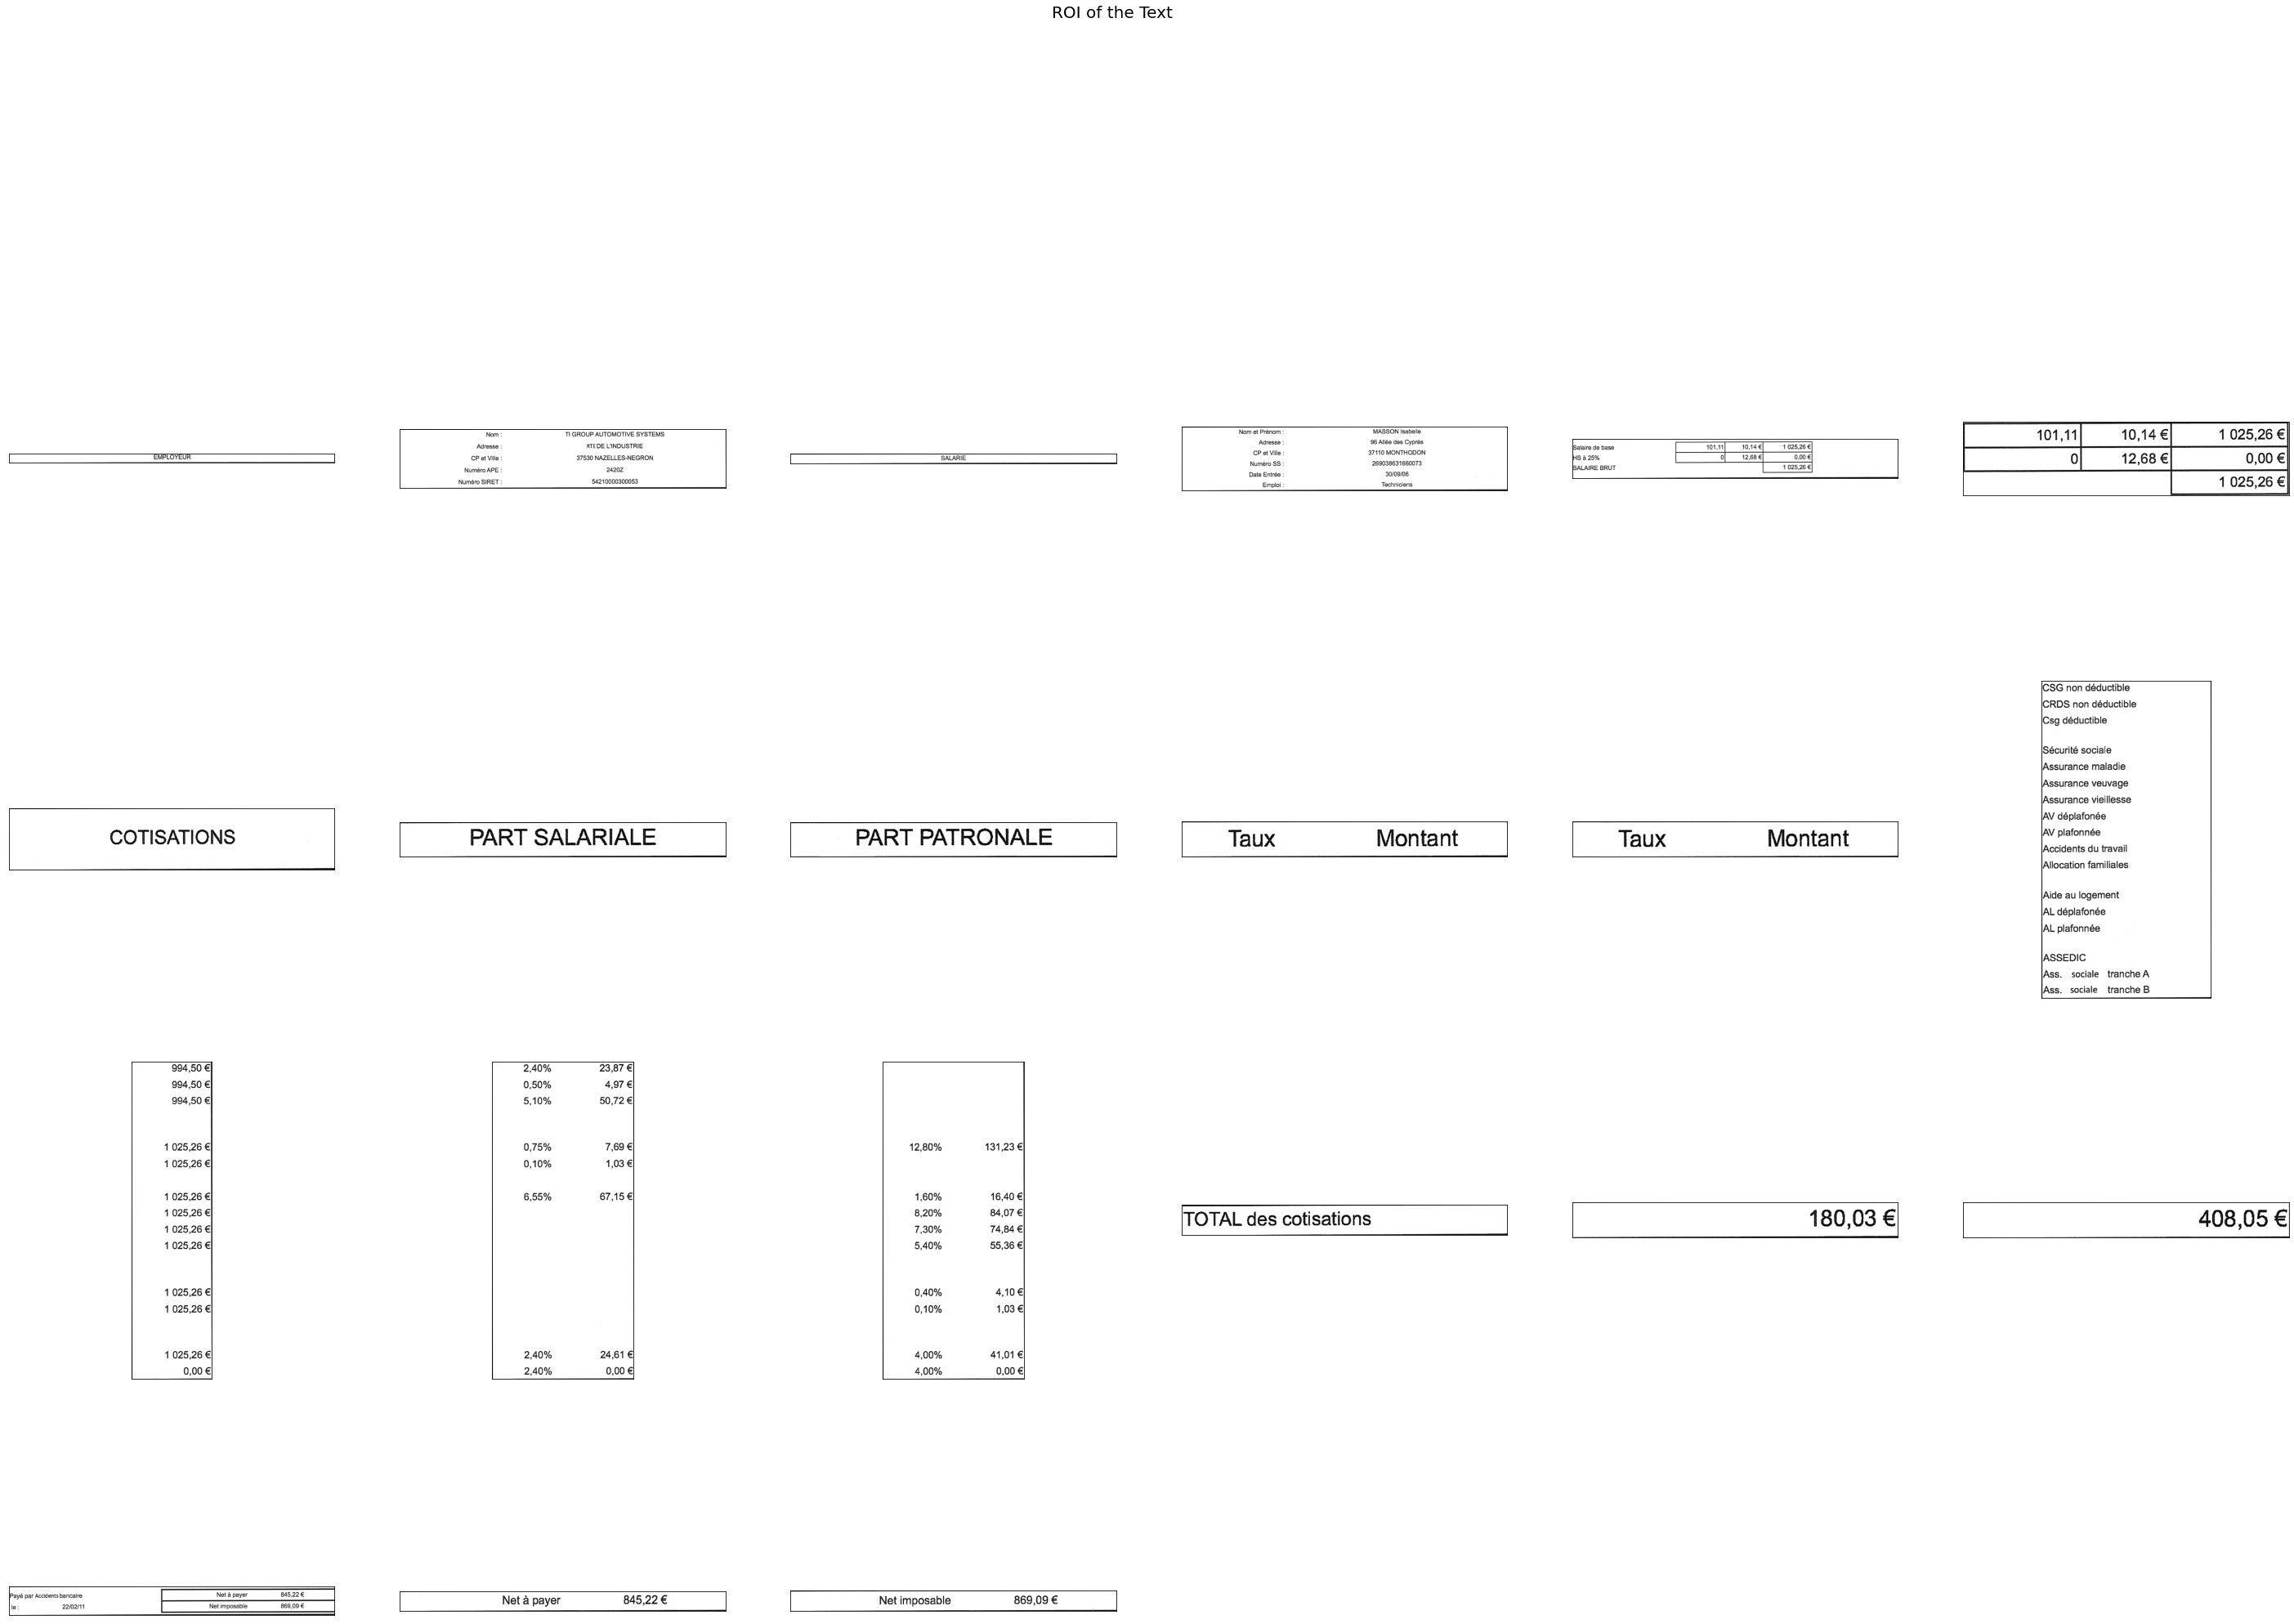

Texts recognised by OCR
emp|oyeur
----------------
nom: adresse: cpetv|||e: numeroape: numeros|ret: t|groupautomot|vesystems rtede|'|ndustr|e 37530naze||esnegron 24202 54210000300053
----------------
sa|ar|e
----------------
nometprenom: adresse: cpetv|||e: numeross: datentre: emp|o|: masson|sabe||e 96a||edescypres 37110monthodon 269038631660073 30/09/06 techn|c|ens
----------------
sa|a|redebase hsa25% sa|a|rebrut
----------------
101111014€102526€ 01268€000€ 102526€
----------------
cot|sat|ons
----------------
partsa|ar|a|e
----------------
partpatrona|e
----------------
tauxmontant
----------------
tauxmontant
----------------
csgnondeduct|b|e crdsnondeduct|b|e csgdeduct|b|e secur|tesoc|a|e assurancema|ad|e assuranceveuvage assurancev|e|||esse avdep|afone avp|afonne acc|dentsdutrava|| a||ocat|onfam|||a|es a|deau|ogement a|dep|afone a|p|afonne assed|c asssoc|a|etranchea asssoc|a|etrancheb
----------------
99450€ 99450€ 99450€ 102526€ 102526€ 102526€ 102526€ 102526€ 102526€ 102526€ 1

In [11]:
def main():
    
    #Preprocess
    #image = load_image('Dataset_2/forgePS/2ps600/Inter_3_PaySlip_Arial_10_2-f_1.jpg')
    image = load_image('Dataset_2/forgePS/ps600/Inter_3_PaySlip_Arial_10_2-f_1.jpg')
    #image = load_image('Dataset_2/genPS/ps600/PaySlip_Arial_10_2-g.jpg')
    #image = load_image('Dataset_2/PaySlip_Arial_10_2-g.tif')
    
    #There are images of two resolutions hence bigger one can be sized down to get similar contour areas
    print(image.shape)
    skew = 0
    if(skew):
        skewed, c = deskew(image)
        orig = skewed
        image, invert, crop_img, shape = region_of_interest(skewed, skewed)
    else:
        orig = image
        image = noise_reduction(image,"gaussian")
        image = binary_preprocess(image)
        image, invert, crop_img, shape = region_of_interest(orig, image)
    
    #Preprocessing for OCR(has to be done) and text recognition
    #print(shape)
    output = tesseract_ocr(crop_img)
    new_ocr_output = ocr_postprocess(output)
    print(new_ocr_output)
    
    '''
    file = open("Output_2/File_8.txt","w")
    for s in new_ocr_output:
        file.writelines(s)
        file.writelines('\n')
    file.close()
    '''
    
if __name__ == "__main__":
    main()
    
#(6992, 4938)
#(3497, 2473)
